First download the gear images using; 

* curl -O https://challenge.blob.core.windows.net/challengefiles/gear_images.zip
* unzip *.zip

Or in windows powershell;

* wget "https://challenge.blob.core.windows.net/challengefiles/gear_images.zip" -OutFile gear_images.zip
* unzip gear_images.zip

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imread, imshow, show, subplot, title, get_cmap, hist
import numpy as np
from PIL import Image, ImageOps, ImageChops
import cv2
import os
import pickle
from pipe import Pipe
from functools import reduce
import operator
from pipe import select,take,as_list
from sklearn import tree
from glob import glob
from PIL import Image
import numpy as np
import re

#Inline Matplot graphics into the notebook
%matplotlib inline 

def resizeImageToSquare(image, desiredSize):
    # old_size[0] is in (width, height) format
    oldSize = image.size

    ratio = float(desiredSize)/max(oldSize)
    newSize = tuple([int(x*ratio) for x in oldSize])

    image = image.resize(newSize, Image.BICUBIC)
    # create a new image and paste the resized on it
    resized = Image.new("L", (desiredSize, desiredSize),0xffffff)
    resized.paste(image, ((desiredSize-newSize[0])//2,
                        (desiredSize-newSize[1])//2))
    return resized

* Load all the gear_images 
* Resize them to 128^2
* Make black and white (we don't want to learn particular colours of tents etc)
* Scale image numbers $\in [0,1]$

In [3]:
%%time

@Pipe
def as_npy(iterable):
    return np.array(iterable)

def getImageTypeFromPath(imagePath):
    return re.search('[^\w](\w+)[^\w]', imagePath)[1]

# note I have obfuscated the names so that people can not google the solutions
imageTypes = {
    'axes': 0, 
    'boots': 1, 
    'carabiners': 2,
    'crampons': 3, 
    'gloves': 4, 
    'hardshell_jackets': 5, 
    'harnesses': 6, 
    'helmets': 7, 
    'insulated_jackets': 8, 
    'pulleys': 9, 
    'rope': 10, 
    'tents': 11, 
}

imageTypesInverted = {v: k for k, v in imageTypes.items()}

xy = ( glob("gear_images/**/*")  
    | select(lambda path: (imageTypes[getImageTypeFromPath(path)], Image.open(path)))     
    # make black and white
    | select(lambda t: (t[0], t[1].convert('L') ) )     
    # make square
    | select(lambda t: (t[0], resizeImageToSquare(t[1], 128)) )     
    | select(lambda t: (t[0], np.array(t[1])))     
    # scale to [0,1]
    | select(lambda t: (t[0], t[1] / 255))     
    | as_list() )

X = xy | select(lambda e: e[1]) | as_list() | as_npy()

# flattened version for classical learning
Xf = X.reshape( X.shape[0], reduce(operator.mul, X.shape[1:], 1)  )
y = xy | select(lambda e: e[0]) | as_list() | as_npy()

print("X", X.shape, "y", y.shape)

X (2122, 128, 128) y (2122,)
Wall time: 18.3 s


Let's plot some of the images so we can see what we are working with

In [4]:
def plotSome(x, y, name='axes'):
    fig = plt.figure(figsize=(8, 6))
    # plot several images
    for i in range(15):
        ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(x[y==imageTypes[name]][i], cmap=plt.cm.bone)

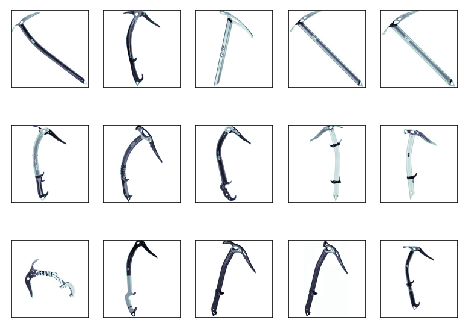

In [5]:
plotSome(X,y,'axes')

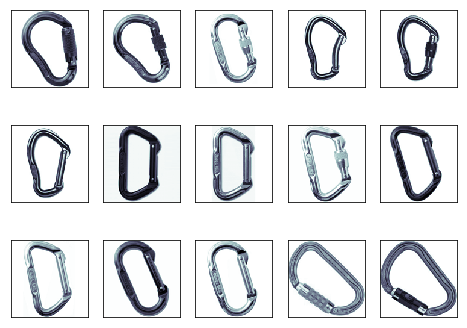

In [6]:
plotSome(X,y,'carabiners')

Let's try plotting one image for every class

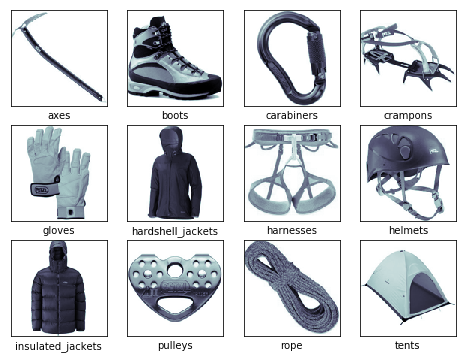

In [7]:
fig = plt.figure(figsize=(8, 6))
# plot several images
i = 0
for key in imageTypes.keys():
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(X[y==imageTypes[key]][0], cmap=plt.cm.bone)
    ax.set_xlabel(key)
    i = i + 1

Let's get a bit more clever now and plot an average image for each class. The result is prettu instructive;

* We can see that roughly half of the boots are inverted
* In most cases there is a clear "signature" to the class, this is part of why this challenge is quite contrived, similar to the MNIST challenge, it should be possible to guess what the class is merely by choosing values for pixels in certain areas. 

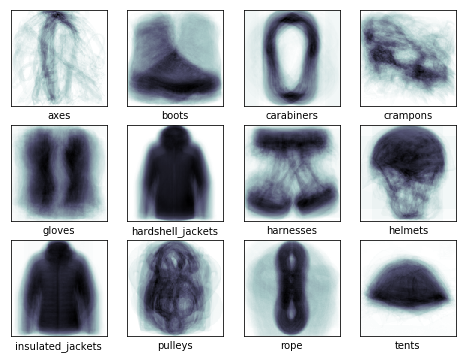

In [8]:
fig = plt.figure(figsize=(8, 6))
# plot several images
i = 0
for key in imageTypes.keys():
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(X[y==imageTypes[key]].mean(axis=0), cmap=plt.cm.bone)
    ax.set_xlabel(key)
    i = i + 1

Let's look at the intensity histogram for each class average. This is interesting;

* In the olden days of computer vision, the onus was on the data scientists themselves to transform the data out of the space domain using some feature. This is the most basic version of that. 
* The reason we used to have transform out of the space domain was that classical algorithms themselves can not learn spatial relationships between pixels and the assumption is that images are typically taken from a variety of angles/environments which *should* render pixel-by-pixel mapping methods unworkable. 
* Turns out that here, while there are some differences between the classes, clearly the previous (2d spatial) information is more instructive to seperate the class

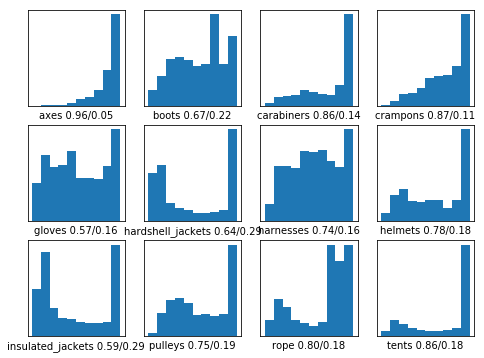

In [9]:
fig = plt.figure(figsize=(8, 6))
# plot several images
i = 0
for key in imageTypes.keys():
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    x = X[y==imageTypes[key]].mean(axis=0).flatten()
    ax.hist(x)
    ax.set_xlabel( f"{key} {x.mean():.2f}/{x.std():.2f}" ) 
    i = i + 1

What is the average image over everything?

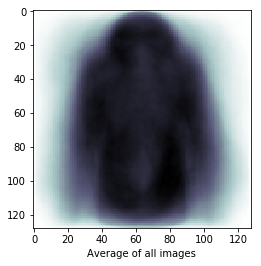

In [10]:
def PlotAverageImage(D):
    x = X[y==imageTypes[key]].mean(axis=0).flatten()
    plt.imshow(D.mean(axis=0), cmap=plt.cm.bone)
    u = plt.xlabel( f"Average of all images" ) 

PlotAverageImage(X)

Jackets seem to be dominating, could this be because;

* The intensity values are higher in jackets
* There are more jackets overall (remember insulated jackets + normal jackets)


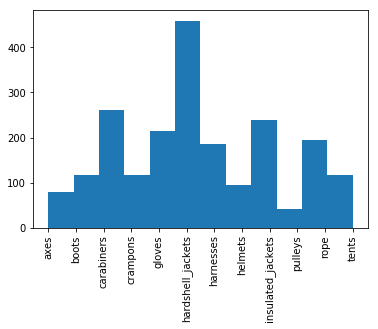

In [12]:
u = plt.hist(y, bins=12)
u = plt.xticks(range(12),imageTypes.keys(), rotation='vertical')

It does indeed appear that our hardshell jackets are dominating due to there being many more of them, also the jackets are around 200 and will have a similar profile which will compound the problem

Let's split the data into a test and train set

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
        y, random_state=0)

print(X_train.shape, X_test.shape)

(1591, 128, 128) (531, 128, 128)


Let's balance the distribution of classes by supersampling in the *train* split. It's important we don't do this on the test split too, as there would be many duplicate images in the test set and it would be trivial to memorise what they are. 

In [62]:
from pipe import chain, as_dict, Pipe, select, take, as_list

@Pipe
def pcycle(iterable):
    while True:
        for it in iterable:
            yield it
        
@Pipe
def as_npy(iterable):
    return np.array(iterable)

def balancedSignalGenerator(X,y,num_classes=12):
    
    class_map = {}
    for c in range(num_classes):
        class_map[c] = list(np.where( y==c)[0])
                            
    D = range(num_classes) \
        | select( lambda c: class_map[c] | pcycle | select( lambda i: (c,X[i]) )  ) \
        | as_list

    while True:
        for c in D:
            yield next(c)[0], next(c)[1]

        
data = balancedSignalGenerator(X_train,y_train) | take(4200) | as_list

X_train_bal = data | select(lambda el: el[1])  | as_list | as_npy
y_train_bal = data | select(lambda el: el[0])  | as_list | as_npy

In [63]:
print( X_train_bal.shape, y_train_bal.shape )

(4200, 128, 128) (4200,)


And we are now balanced!

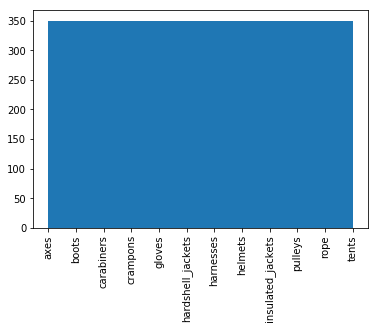

In [64]:
plt.hist(y_train_bal,bins=12)
u = plt.xticks(range(12),imageTypes.keys(), rotation='vertical')

Now, let's plot the average image again. This looks a little bit more reasonable i.e. there is a consistent "contribution" to the mixture from all 12 classes. If anything it's now the rope which is slightly dominating, I assume because its being "boosted" from mixing with the jackets which entirely intersect. 

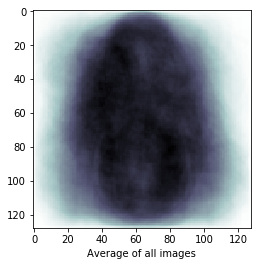

In [65]:
PlotAverageImage(X_train_bal)

Helper function to convert label indexes i.e. {0,1,2...} into labels i.e. {"axes","carabiners"...}

In [66]:
def ConvertIndexToLabel(indexes):
    return list( indexes ) | select( lambda i: imageTypesInverted[i] ) | as_list 

Let's run a basic decision tree algorithm on the data i.e. ID3 algorithm

In [108]:
%%time

from sklearn import tree
from sklearn import metrics

def flattenImage(I, dim=128):
    return I.reshape(I.shape[0], dim*dim)

# expects flattened data going in
def ID3(xtr,xte,ytr,yte):
    classifier = tree.DecisionTreeClassifier()
    clf = classifier.fit(xtr, ytr)
    p = clf.predict(xte)
    print(
        metrics.classification_report(
            ConvertIndexToLabel(yte), 
            ConvertIndexToLabel(p)
        ))
    return p

y_pred = ID3( flattenImage(X_train_bal), flattenImage(X_test), y_train_bal, y_test )

                   precision    recall  f1-score   support

             axes       0.05      0.07      0.06        28
            boots       0.32      0.41      0.36        22
       carabiners       0.26      0.17      0.21        63
         crampons       0.36      0.37      0.36        38
           gloves       0.36      0.31      0.34        51
hardshell_jackets       0.50      0.59      0.54       106
        harnesses       0.26      0.27      0.26        45
          helmets       0.23      0.29      0.25        24
insulated_jackets       0.33      0.16      0.22        68
          pulleys       0.15      0.14      0.15        14
             rope       0.21      0.28      0.24        43
            tents       0.35      0.38      0.37        29

      avg / total       0.32      0.32      0.31       531

Wall time: 1min


We get about ~.71 f-1 on this which to be clear is training on the supersampled train split and tested on the original test split

Here is a function which let's us plot a nice confusion matrix

In [33]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plotConfusion(yy, p, title='Confusion matrix'):
    cnf_matrix = metrics.confusion_matrix(yy, p)
    np.set_printoptions(precision=2)

    cm_labels = list(set(imageTypes.keys()))
    cm_labels.sort()

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(6, 6))
    plot_confusion_matrix(cnf_matrix, classes=cm_labels,
                          title=title)

Here is the confusion matrix for the supersampled train split and tested on the original test split. Clearly the biggest problem is confusing the two jacket classes

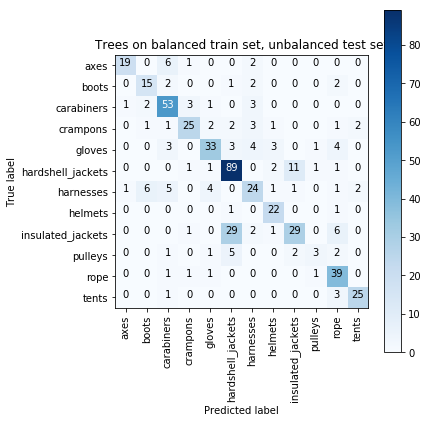

In [68]:
plotConfusion(y_test, y_pred, title='Trees on balanced train set, unbalanced test set')

Now let's add some white noise to the backgrounds, the hypothesis on the table is that it's just learning where the white pixels are...

In [69]:
%%time

from random import uniform
from pipe import take, select, as_list, Pipe

import random

@Pipe
def pshuffle(l):
    random.shuffle(l)
    return l

def noiseImages( images ):
    images_whitenoise = images

    mask = images_whitenoise>0.95
    vals = range(np.count_nonzero(mask)) | select( lambda n: uniform(0, 1)) | as_list()

    # Assign back into X
    images_whitenoise[mask] = vals
    return images_whitenoise
    
X_test_whitenoise = noiseImages( X_test )
X_train_bal_whitenoise = noiseImages( X_train_bal )

Wall time: 16.5 s


And let's plot 16 test images to see if the backgrounds have been noised

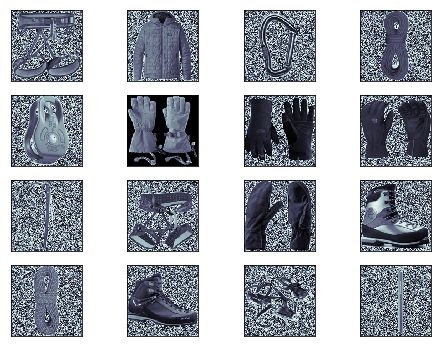

In [70]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

noisy_images = range( X_test_whitenoise.shape[0] )     \
    | as_list()     \
    | pshuffle()     \
    | take(16)     \
    | select( lambda i: X_test_whitenoise[i] )     \
    | as_list()

fig = plt.figure(figsize=(8, 6))
# plot several images
i = 0
for img in noisy_images:
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(img.reshape(128,128), cmap=plt.cm.bone)
    i = i + 1

Now let's run trees (ID3) on noisy images, we are expecting the accuracy to plummet

In [71]:
print(X_train_bal_whitenoise.shape, X_test_whitenoise.shape, y_train_bal.shape, y_test.shape)

(4200, 128, 128) (531, 128, 128) (4200,) (531,)


                   precision    recall  f1-score   support

             axes       0.07      0.11      0.09        28
            boots       0.38      0.41      0.39        22
       carabiners       0.29      0.22      0.25        63
         crampons       0.29      0.24      0.26        38
           gloves       0.35      0.29      0.32        51
hardshell_jackets       0.47      0.59      0.52       106
        harnesses       0.26      0.18      0.21        45
          helmets       0.18      0.25      0.21        24
insulated_jackets       0.32      0.12      0.17        68
          pulleys       0.07      0.07      0.07        14
             rope       0.18      0.23      0.20        43
            tents       0.22      0.38      0.28        29

      avg / total       0.30      0.30      0.29       531

Wall time: 59.2 s


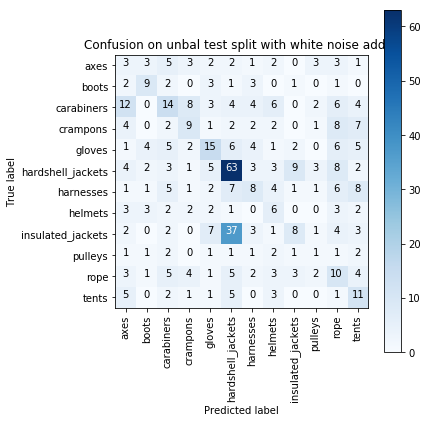

In [73]:
%%time

y_pred = ID3(flattenImage(X_train_bal_whitenoise), 
             flattenImage(X_test_whitenoise), 
             y_train_bal, y_test)

plotConfusion(y_test, y_pred, title='Confusion on unbal test split with white noise added')

And indeed, the accuracy plumets to ~.29 average f-1 score!! Ouch.

It's now shockingly bad on axes, helmets and pulleys, let's look at the confusion matrix.

Pretty bad across the board but what we do see is that it works much better on hardshell jackets! This is pretty much because we have more hardshell jackets than any other class, so the classifier can "guess" hardshell jackets more often. We now have three things we can do to address this;

* Supersample the test set so that the label distribution is balanced like the training set, this would result in many duplicate images
* Subsample the test set so that the label distribution is balanced, this would result in a much smaller set
* Supersample the test set with augmentation i.e. random translations, scale/rotation transforms (maybe even affine). 

There are tradeoffs here. The first option will effectively be testing over many of the same images which might constitute cheating. The second option would result in a much smaller sample. The third option is safer but would destroy classical methods like trees which perform pixel mapping. We want to do augmentation anyway soon to demonstrate this. 

First, let's supersample the test set and renoise, and see what we get

                   precision    recall  f1-score   support

             axes       0.33      0.43      0.37       100
            boots       0.48      0.54      0.51       100
       carabiners       0.08      0.12      0.10       100
         crampons       0.14      0.16      0.15       100
           gloves       0.29      0.30      0.30       100
hardshell_jackets       0.30      0.55      0.38       100
        harnesses       0.26      0.18      0.21       100
          helmets       0.29      0.24      0.26       100
insulated_jackets       0.50      0.24      0.32       100
          pulleys       0.45      0.14      0.21       100
             rope       0.24      0.24      0.24       100
            tents       0.27      0.20      0.23       100

      avg / total       0.30      0.28      0.27      1200

Wall time: 1min 37s


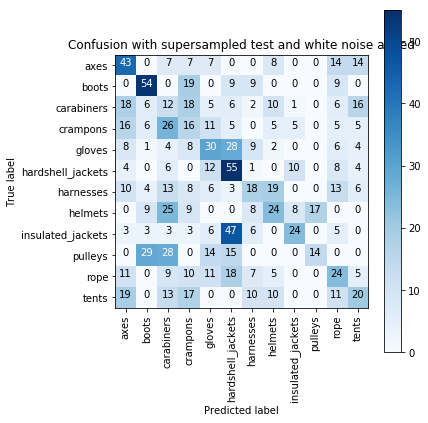

In [55]:
%%time
data = balancedSignalGenerator(X_test,y_test) | take(1200) | as_list

X_test_bal = data | select(lambda el: el[1])  | as_list | as_npy
y_test_bal = data | select(lambda el: el[0])  | as_list | as_npy

X_test_bal_whitenoise = noiseImages( X_test_bal )

y_test, y_pred = ID3(flattenImage(X_train_bal_whitenoise), 
                     flattenImage(X_test_bal_whitenoise), y_train_bal, y_test_bal)

plotConfusion(y_test, y_pred, title='Confusion with supersampled test and white noise added')

This is interesting, so the F-1 score is similar but the results are way more balanced i.e. the confusion matrix is telling a much better story and we can actually intepret what is boing confused with what

Another approach people try in these circumstances with classical algorithms is to use PCA to reduce the dimensionality first. Because we have a lot of dimensions (128^2) it means we can't really use algorithms like SVM because we would run out of memory computing the $XX'$ matrix used in the dual formulation

In [109]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=50)
pca.fit(X_train_bal_whitenoise.reshape(4200,128*128), y=y_train)

X_train_bal_whitenoise_pca = pca.transform(X_train_bal_whitenoise.reshape(4200,128*128))
X_test_bal_whitenoise_pca = pca.transform(X_test_bal_whitenoise.reshape(1200,128*128))

Let's visualise the first principal components

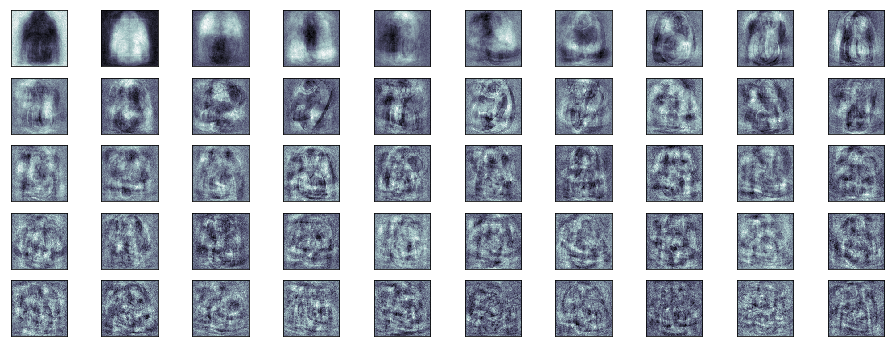

In [110]:
fig = plt.figure(figsize=(16, 6))
for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(128,128),
              cmap=plt.cm.bone)

What we observe here is that the principal component do not magically transform the data out of the space domain -- the x/y dimensions are still highly relevant. But it does show us something about the variance between pixels accross classes i.e. we can start to see the shapes of different items

Let's try running an ID3 on the PCA data

                   precision    recall  f1-score   support

             axes       0.65      0.57      0.61       100
            boots       0.73      0.73      0.73       100
       carabiners       0.30      0.52      0.38       100
         crampons       0.91      0.41      0.57       100
           gloves       0.44      0.54      0.49       100
hardshell_jackets       0.39      0.72      0.50       100
        harnesses       0.31      0.39      0.34       100
          helmets       0.66      0.49      0.56       100
insulated_jackets       0.75      0.44      0.55       100
          pulleys       0.52      0.14      0.22       100
             rope       0.39      0.42      0.40       100
            tents       0.56      0.50      0.53       100

      avg / total       0.55      0.49      0.49      1200

Wall time: 308 ms


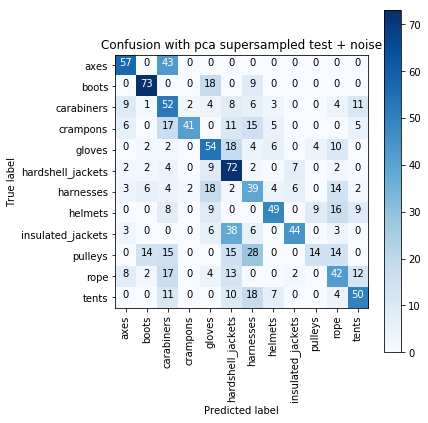

In [123]:
%%time
y_pred = ID3(X_train_bal_whitenoise_pca, X_test_bal_whitenoise_pca, y_train_bal, y_test_bal)

plotConfusion(y_test_bal, y_pred, title='Confusion with pca supersampled test + noise')

It is actually a significant improvement i.e. f-1 improves from .27->.49

Now that we have only 50 features, it's computationally tractable to run something like an SVM, let's try that

                   precision    recall  f1-score   support

             axes       0.58      0.64      0.61       100
            boots       0.89      0.91      0.90       100
       carabiners       0.34      0.84      0.49       100
         crampons       0.89      0.47      0.61       100
           gloves       0.82      0.82      0.82       100
hardshell_jackets       0.55      0.89      0.68       100
        harnesses       0.81      0.66      0.73       100
          helmets       0.85      0.66      0.74       100
insulated_jackets       0.88      0.63      0.73       100
          pulleys       1.00      0.14      0.25       100
             rope       0.71      0.78      0.74       100
            tents       0.93      0.67      0.78       100

      avg / total       0.77      0.68      0.67      1200



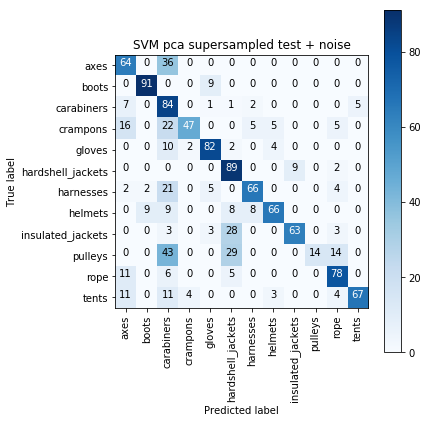

In [139]:
from sklearn import svm
clf = svm.SVC(C=10., kernel='rbf', gamma=0.001)
clf.fit(X_train_bal_whitenoise_pca, y_train_bal)
y_pred = clf.predict(X_test_bal_whitenoise_pca)
print(metrics.classification_report(ConvertIndexToLabel(y_test_bal), ConvertIndexToLabel(y_pred)))
plotConfusion(y_test_bal, y_pred, title='SVM pca supersampled test + noise')

This is actually pretty good we went from .49 on trees to .69 here with SVM, performing very well on boots and badly on pulleys axes and carabiners, some confusion between the jackets. 

The hypothesis on the table is that a CNN would work better because it can model local spatial patterns which are somewhat invariant to translation

First to use a CNN we need to add an explicit colour channel back in, even if it's only 1, also we need to one-hot encode the labels

In [137]:
from keras.utils import to_categorical

X_train_bal_whitenoise_1 = X_train_bal_whitenoise.reshape(4200,128,128,1)
y_train_bal_oh = to_categorical(y_train_bal, num_classes=12)
y_test_bal_oh = to_categorical(y_test_bal, num_classes=12)
X_test_bal_whitenoise_1 = X_test_bal_whitenoise.reshape(1200,128,128,1)

In [138]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(128,128,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(12, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
history = model.fit(X_train_bal_whitenoise_1, y_train_bal_oh, 
                    epochs=5, batch_size=100, 
                    validation_data=(X_test_bal_whitenoise_1, y_test_bal_oh))


Train on 4200 samples, validate on 1200 samples
Epoch 1/5
4200/4200 [==============================] - 149s 36ms/step - loss: 1.8038 - acc: 0.5333 - val_loss: 0.5361 - val_acc: 0.8525
Epoch 2/5
4200/4200 [==============================] - 149s 35ms/step - loss: 0.1510 - acc: 0.9536 - val_loss: 0.4410 - val_acc: 0.8708
Epoch 3/5
4200/4200 [==============================] - 148s 35ms/step - loss: 0.0211 - acc: 0.9962 - val_loss: 0.4132 - val_acc: 0.8725
Epoch 4/5
4200/4200 [==============================] - 150s 36ms/step - loss: 0.0064 - acc: 0.9998 - val_loss: 0.3938 - val_acc: 0.8650
Epoch 5/5
4200/4200 [==============================] - 149s 35ms/step - loss: 0.0084 - acc: 0.9990 - val_loss: 0.4076 - val_acc: 0.8908


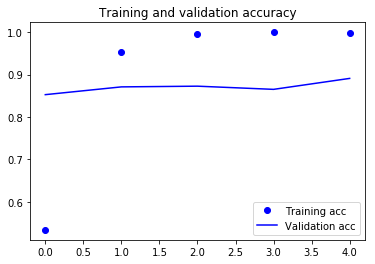

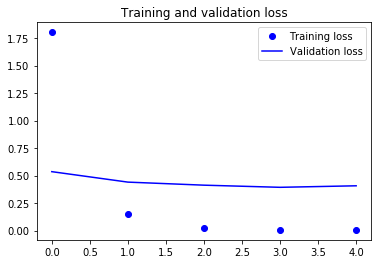

In [140]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [143]:
from numpy import argmax
y_pred = model.predict(X_test_bal_whitenoise_1)
y_pred.shape
print(metrics.classification_report(ConvertIndexToLabel(y_test_bal), ConvertIndexToLabel(argmax(y_pred,axis=1))))

                   precision    recall  f1-score   support

             axes       0.95      1.00      0.98       100
            boots       1.00      0.91      0.95       100
       carabiners       1.00      0.93      0.96       100
         crampons       0.93      0.90      0.91       100
           gloves       0.63      0.83      0.72       100
hardshell_jackets       0.70      0.96      0.81       100
        harnesses       0.94      0.97      0.96       100
          helmets       0.96      0.91      0.93       100
insulated_jackets       0.90      0.70      0.79       100
          pulleys       1.00      0.71      0.83       100
             rope       0.89      0.93      0.91       100
            tents       1.00      0.94      0.97       100

      avg / total       0.91      0.89      0.89      1200



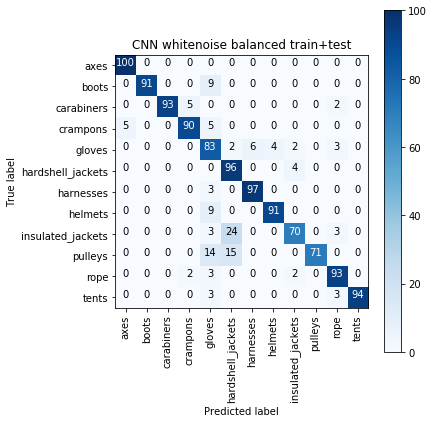

In [147]:
plotConfusion(y_test_bal, argmax(y_pred,axis=1), title='CNN whitenoise balanced train+test')

The CNN on the balanced noisy data works very well indeed, demonstrating the power of being able to learn invariant spatial features between pixels

Now we are going to simulate a real-world scenario and apply random mutations to the images before splitting and training